In [1]:
!nvidia-smi

Sat Feb  5 16:09:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!python -m pip install "dask[complete]"

     |████████████████████████████████| 830 kB 5.1 MB/s 
     |████████████████████████████████| 133 kB 14.8 MB/s 
     |████████████████████████████████| 822 kB 32.2 MB/s 
     |████████████████████████████████| 802 kB 39.2 MB/s 
     |████████████████████████████████| 802 kB 37.5 MB/s 
     |████████████████████████████████| 793 kB 41.1 MB/s 
     |████████████████████████████████| 793 kB 34.3 MB/s 
     |████████████████████████████████| 791 kB 36.3 MB/s 
     |████████████████████████████████| 786 kB 38.1 MB/s 
     |████████████████████████████████| 779 kB 40.8 MB/s 
     |████████████████████████████████| 778 kB 40.0 MB/s 
     |████████████████████████████████| 776 kB 7.7 MB/s 
     |████████████████████████████████| 769 kB 32.3 MB/s 
     |████████████████████████████████| 766 kB 10.5 MB/s 
     |████████████████████████████████| 1.0 MB 31.5 MB/s 
     |████████████████████████████████| 722 kB 26.4 MB/s 
     |████████████████████████████████| 722 kB 43.4 MB/s 
     |██████████

In [4]:
import os
import random
import numpy as np
import pandas as pd 
from skimage import io
from skimage import color
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from dask.array.image import imread
from dask import bag, threaded
from dask.diagnostics import ProgressBar
import cv2
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
import math

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint, LearningRateScheduler
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import image 
from tensorflow.keras.layers import BatchNormalization
from keras import optimizers
from tensorflow.keras.optimizers import Adam as Adam

In [5]:
## Check if system is using GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2960997195786946914
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11320098816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1034245099924521353
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
xla_global_id: 416903419
]


In [6]:
!unzip '/content/drive/MyDrive/Kaggle Datasets/State Farm Distracted Driver Detection/imgs.zip'

Streaming output truncated to the last 5000 lines.
  inflating: train/c7/img_566.jpg    
  inflating: train/c7/img_56636.jpg  
  inflating: train/c7/img_56661.jpg  
  inflating: train/c7/img_56699.jpg  
  inflating: train/c7/img_56717.jpg  
  inflating: train/c7/img_56724.jpg  
  inflating: train/c7/img_56768.jpg  
  inflating: train/c7/img_56779.jpg  
  inflating: train/c7/img_56849.jpg  
  inflating: train/c7/img_56899.jpg  
  inflating: train/c7/img_56938.jpg  
  inflating: train/c7/img_5706.jpg   
  inflating: train/c7/img_57076.jpg  
  inflating: train/c7/img_57122.jpg  
  inflating: train/c7/img_57137.jpg  
  inflating: train/c7/img_5715.jpg   
  inflating: train/c7/img_57278.jpg  
  inflating: train/c7/img_57321.jpg  
  inflating: train/c7/img_57345.jpg  
  inflating: train/c7/img_57355.jpg  
  inflating: train/c7/img_5741.jpg   
  inflating: train/c7/img_57433.jpg  
  inflating: train/c7/img_5753.jpg   
  inflating: train/c7/img_57559.jpg  
  inflating: train/c7/img_57594.jpg  

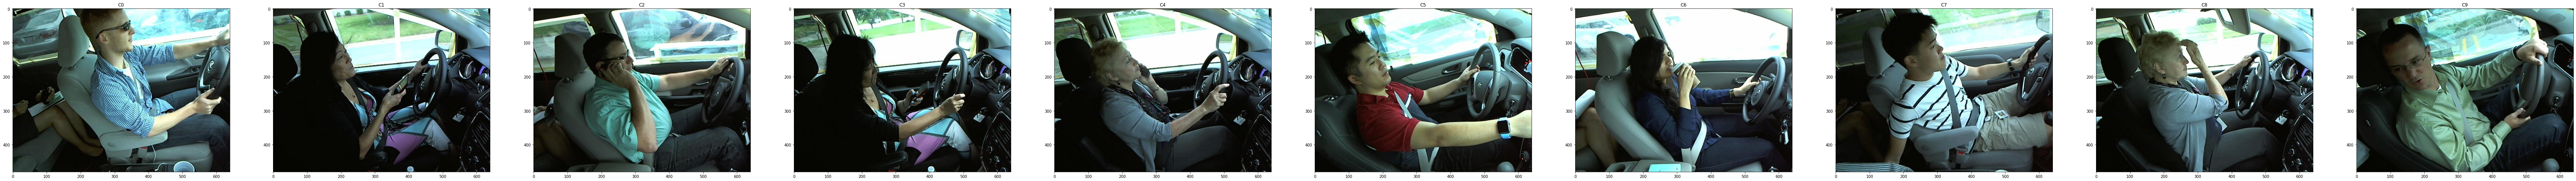

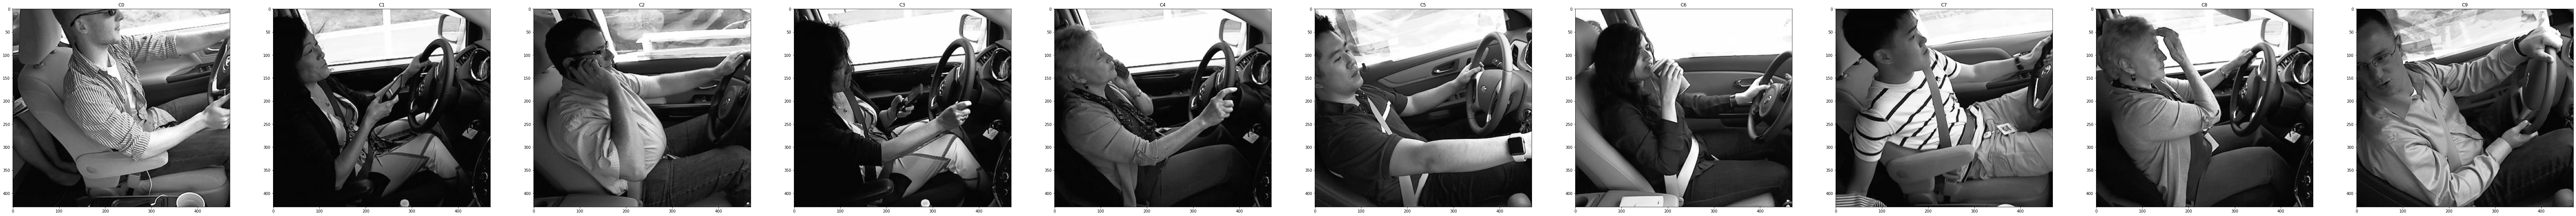

In [7]:
# getting one image per label
f, ax = plt.subplots(1,10, figsize = (120,120))
for i in range(10):
  #print('now we are in the folder C',i)
    labels = imread("/content/train/c"+str(i)+"/*.jpg")
    for j in range(1):
        img = labels[j]
        label = i
        ax[i].imshow(img)
        ax[i].set_title('C'+str(i))
        plt.show

# After Editing
f, ax = plt.subplots(1,10, figsize = (120,120))
for i in range(10):
  #print('now we are in the folder C',i)
    labels = imread("/content/train/c"+str(i)+"/*.jpg")
    for j in range(1):
        img = labels[j]
        img = color.rgb2gray(img)
        img = img[50:,120:-50]
        label = i
        ax[i].imshow(img,cmap='gray')
        ax[i].set_title('C'+str(i))
        plt.show


In [8]:
train_image = []
image_label = []


for i in range(10):
    print('now we are in the folder C',i)
    labels = imread("/content/train/c"+str(i)+"/*.jpg")
    for j in range(len(labels)):
  #for j in range(500):
        img = labels[j]
        img = color.rgb2gray(img)
        img = img[50:,120:-50]
        img = cv2.resize(img,(112,112))
        label = i
        train_image.append([img,label])
        image_label.append(i)   

now we are in the folder C 0
now we are in the folder C 1
now we are in the folder C 2
now we are in the folder C 3
now we are in the folder C 4
now we are in the folder C 5
now we are in the folder C 6
now we are in the folder C 7
now we are in the folder C 8
now we are in the folder C 9


In [9]:
## Randomly shuffling the images

import random
random.shuffle(train_image)

In [10]:
## Splitting the image and label to two different lists

X = []
Y = []
for features,labels in train_image:
    X.append(features)
    Y.append(labels)

print (len(X), len(Y))

22424 22424


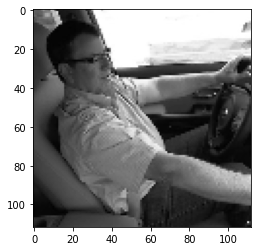

5


In [11]:
plt.imshow(X[5],cmap= 'gray')
plt.show()
print(Y[5])

In [12]:
## Converting images to nparray. Encoding the Y

X = np.array(X).reshape(-1,112,112,1)
Y = to_categorical(Y)
print (X.shape)

(22424, 112, 112, 1)


In [13]:
print(Y[5])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [14]:
## Designing the Layers
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.2)

In [15]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(17939, 112, 112, 1) (4485, 112, 112, 1) (17939, 10) (4485, 10)


In [16]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, kernel_size=(3,3),activation='relu',input_shape=(112,112,1),padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
  tf.keras.layers.Conv2D(64, kernel_size=(3,3),activation='relu',input_shape=(112,112,1),padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(64, kernel_size=(3,3),activation='relu',input_shape=(112,112,1),padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
  tf.keras.layers.Conv2D(128, kernel_size=(3,3),activation='relu',input_shape=(112,112,1),padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 56, 56, 64)       256       
 hNormalization)                                                 
                                                        

In [17]:
adam = tf.keras.optimizers.Adam(
            learning_rate=0.0005, 
            beta_1=0.9, 
            beta_2=0.999, 
            epsilon=1e-07,
            name='Adam'
)
def step_decay(epoch):
    initial_lrate = 0.0005
    drop = 0.9
    epochs_drop = 1
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])
checkpoint = ModelCheckpoint(
                'model.h5',
                monitor='val_acc',
                verbose=0,
                save_best_only=True,
                mode='max'
                )

lrate = LearningRateScheduler(step_decay)

In [18]:
## Fitting the model
history = model.fit(X_train, y_train, batch_size = 32, epochs = 25, validation_data=(X_test, y_test), callbacks=[checkpoint, lrate])

Epoch 1/25
561/561 [==============================] - 53s 76ms/step - loss: 1.2896 - accuracy: 0.5626 - val_loss: 0.5054 - val_accuracy: 0.8250 - lr: 4.5000e-04
Epoch 2/25
561/561 [==============================] - 44s 78ms/step - loss: 0.1996 - accuracy: 0.9408 - val_loss: 0.0892 - val_accuracy: 0.9744 - lr: 4.0500e-04
Epoch 3/25
561/561 [==============================] - 44s 78ms/step - loss: 0.0863 - accuracy: 0.9744 - val_loss: 0.0468 - val_accuracy: 0.9864 - lr: 3.6450e-04
Epoch 4/25
561/561 [==============================] - 42s 74ms/step - loss: 0.0562 - accuracy: 0.9856 - val_loss: 0.0430 - val_accuracy: 0.9895 - lr: 3.2805e-04
Epoch 5/25
561/561 [==============================] - 41s 74ms/step - loss: 0.0432 - accuracy: 0.9880 - val_loss: 0.0722 - val_accuracy: 0.9824 - lr: 2.9525e-04
Epoch 6/25
561/561 [==============================] - 44s 78ms/step - loss: 0.0321 - accuracy: 0.9905 - val_loss: 0.0512 - val_accuracy: 0.9897 - lr: 2.6572e-04
Epoch 7/25
561/561 [==============

In [19]:
model.save('my_h5_model.h5')

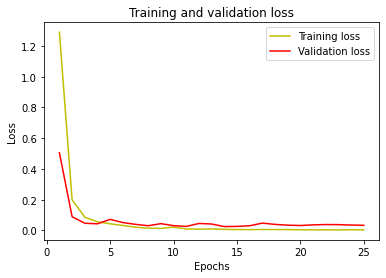

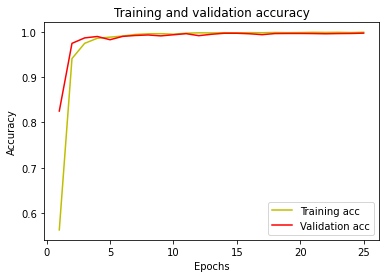

In [20]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
predictions = model.predict(X_test)
predictions

array([[1.3463080e-17, 4.8229014e-15, 2.5608229e-11, ..., 2.2932080e-16,
        9.7345985e-11, 2.5064325e-17],
       [3.4078970e-26, 1.0000000e+00, 8.1075339e-20, ..., 0.0000000e+00,
        4.9680230e-33, 0.0000000e+00],
       [8.0185416e-30, 2.6479773e-24, 9.3286234e-19, ..., 4.8619430e-26,
        2.8751946e-18, 2.1304970e-30],
       ...,
       [4.6948828e-10, 2.7303774e-16, 2.5154624e-19, ..., 8.0154191e-12,
        6.3953820e-10, 1.0000000e+00],
       [1.0854202e-21, 3.3867638e-31, 5.2244343e-31, ..., 1.2421259e-21,
        4.2965440e-12, 1.0000000e+00],
       [6.6469825e-34, 4.0821057e-29, 2.5834190e-19, ..., 4.3398149e-28,
        2.5371816e-21, 3.6337211e-36]], dtype=float32)

In [22]:
# select the index with the maximum probability
predictions = np.argmax(predictions,axis = 1)

predictions = pd.Series(predictions,name="Label")

In [23]:
predictions

0       6
1       1
2       6
3       1
4       6
       ..
4480    3
4481    6
4482    9
4483    9
4484    6
Name: Label, Length: 4485, dtype: int64

In [24]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [25]:
y_test1 = y_test

In [26]:
#Converting OneHotEncoded Values to Labels
y_test1 = pd.Series(np.argmax(y_test1, axis=1)) 

In [27]:
from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix
cm = confusion_matrix(y_test1,predictions)
print(np.around(cm/cm.sum(axis=1, keepdims=True)*100,1))

[[100.    0.    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  0.2  99.8   0.    0.    0.    0.    0.    0.    0.    0. ]
 [  0.    0.  100.    0.    0.    0.    0.    0.    0.    0. ]
 [  0.    0.    0.  100.    0.    0.    0.    0.    0.    0. ]
 [  0.    0.    0.    0.2  99.8   0.    0.    0.    0.    0. ]
 [  0.    0.    0.    0.    0.2  99.8   0.    0.    0.    0. ]
 [  0.    0.    0.    0.    0.    0.   99.8   0.2   0.    0. ]
 [  0.    0.    0.    0.    0.    0.    0.  100.    0.    0. ]
 [  0.    0.    0.    0.    0.3   0.    0.5   0.   98.2   1.1]
 [  0.    0.    0.    0.    0.2   0.    0.    0.    0.5  99.3]]


In [28]:
#fig, ax = plt.subplots(figsize=(15,10))
#sns.heatmap(cm,annot=True, linewidths=.5, ax=ax)

In [29]:
print(classification_report(y_test1, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       526
           1       1.00      1.00      1.00       467
           2       1.00      1.00      1.00       454
           3       1.00      1.00      1.00       465
           4       0.99      1.00      1.00       445
           5       1.00      1.00      1.00       469
           6       1.00      1.00      1.00       461
           7       1.00      1.00      1.00       414
           8       0.99      0.98      0.99       379
           9       0.99      0.99      0.99       405

    accuracy                           1.00      4485
   macro avg       1.00      1.00      1.00      4485
weighted avg       1.00      1.00      1.00      4485

